# WAVELET TRANSFORM 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import pywt
import pandas as pd
import scaleogram as scg 
from scipy import signal

### Into 

In [2]:
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(average_over))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
def plot_fft_plus_power(time, signal, x_limit = 100):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    ax.set_xlim(0, x_limit)
    plt.show()

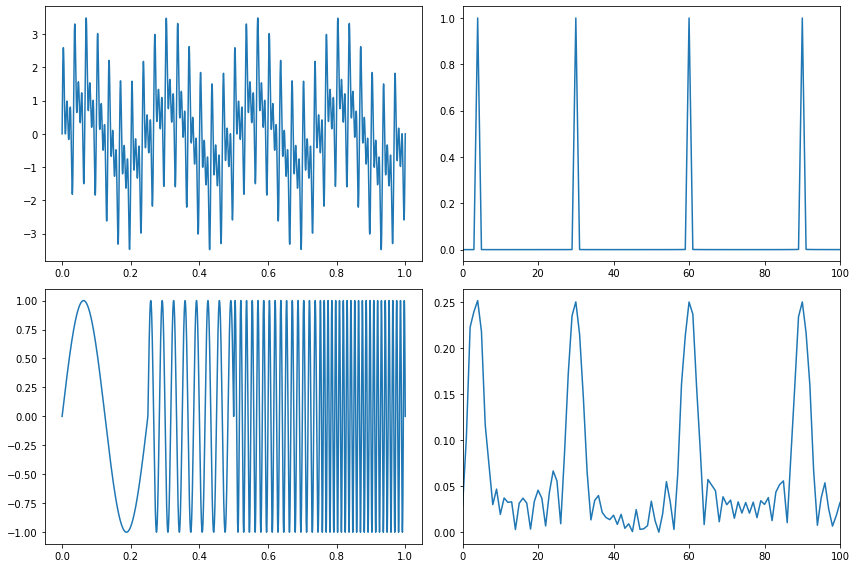

In [3]:
t_n = 1
N = 100000
T = t_n / N
f_s = 1/T
 
xa = np.linspace(0, t_n, num=N)
xb = np.linspace(0, t_n/4, num=N//4)
 
frequencies = [4, 30, 60, 90]
y1a, y1b = np.sin(2*np.pi*frequencies[0]*xa), np.sin(2*np.pi*frequencies[0]*xb)
y2a, y2b = np.sin(2*np.pi*frequencies[1]*xa), np.sin(2*np.pi*frequencies[1]*xb)
y3a, y3b = np.sin(2*np.pi*frequencies[2]*xa), np.sin(2*np.pi*frequencies[2]*xb)
y4a, y4b = np.sin(2*np.pi*frequencies[3]*xa), np.sin(2*np.pi*frequencies[3]*xb)
 
composite_signal1 = y1a + y2a + y3a + y4a
composite_signal2 = np.concatenate([y1b, y2b, y3b, y4b])
 
f_values1, fft_values1 = get_fft_values(composite_signal1, T, N, f_s)
f_values2, fft_values2 = get_fft_values(composite_signal2, T, N, f_s)
 
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
axarr[0,0].plot(xa, composite_signal1)
axarr[1,0].plot(xa, composite_signal2)
axarr[0,1].plot(f_values1, fft_values1)
axarr[1,1].plot(f_values2, fft_values2)

axarr[0,1].set_xlim(0, 100)
axarr[1,1].set_xlim(0, 100)

plt.tight_layout()
plt.show()

![title](Comparisonoftransformations.jpg)

The Wavelet Transform has:

* for small frequency values a high resolution in the frequency domain, low resolution in the time-domain,
* for large frequency values a low resolution in the frequency domain, high resolution in the time-domain.

### How? What?

![title](Wavelet-Out1.jpg)

* The sine-wave is infinitely long and the Wavelet is localized in time
* The Wavelet is localized in time, we can multiply our signal with the wavelet at different locations in time
* We start with the beginning of our signal and slowly move the wavelet towards the end of the signal
* This is a convolution

In [4]:
 print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


/Users/damirnurtdinov/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


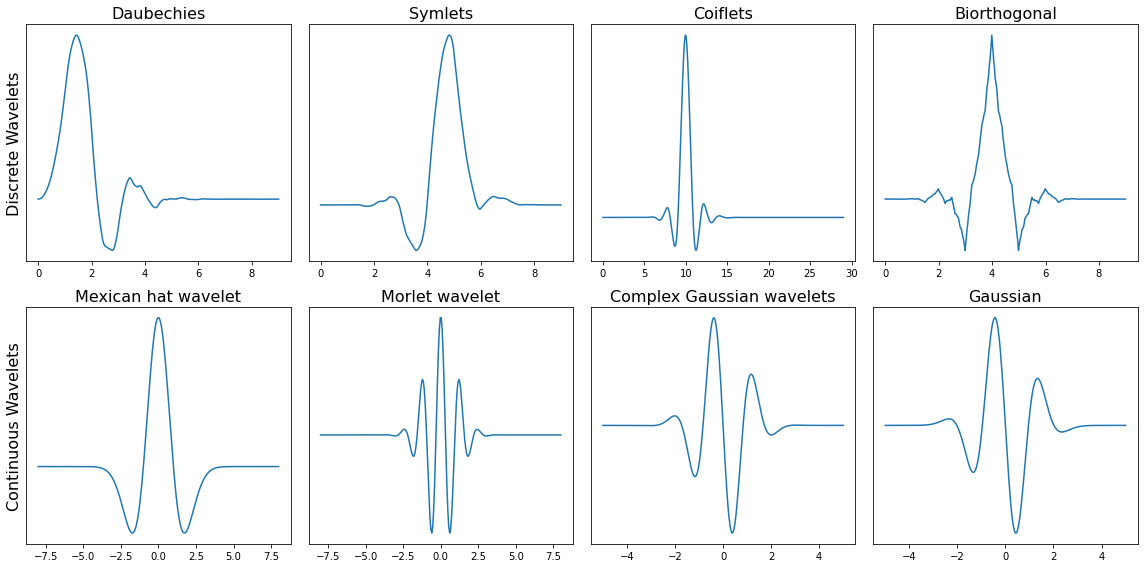

In [5]:
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
 
list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]
 
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
 
plt.tight_layout()
plt.show()

### Let's see

In [6]:
dataset = pd.read_csv('first.csv', header = None)

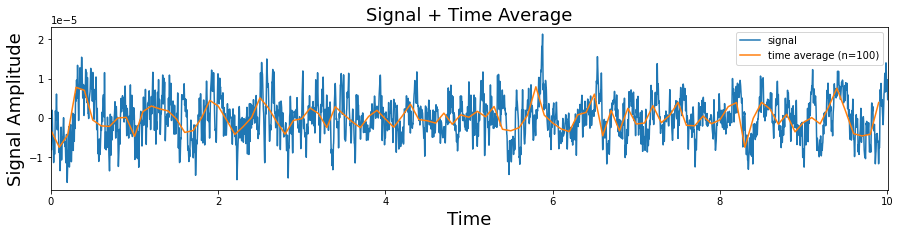

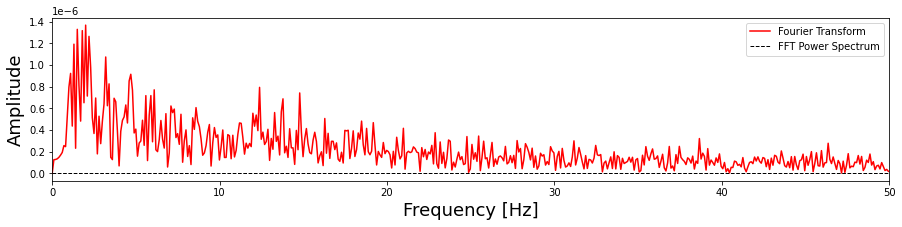

In [7]:
df_nino = dataset.iloc[6, :]
N = df_nino.shape[0]
t0=0
dt=0.001
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
 
plot_signal_plus_average(time, signal, average_over = 100)
plot_fft_plus_power(time, signal, x_limit = 50)

<AxesSubplot:title={'center':'Continuous Wavelet Transform Amplitude Spectrum'}, xlabel='Time/spatial domain', ylabel='Period'>

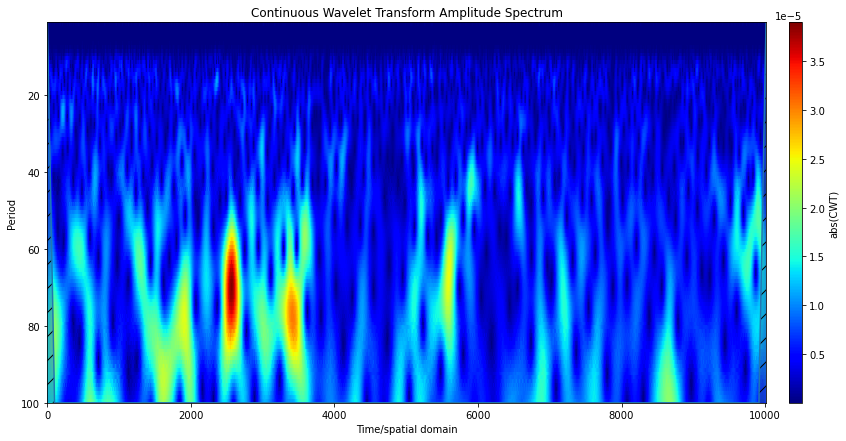

In [8]:
scales = scg.periods2scales(np.arange(1, 100, 1))
coikw = {'alpha': 0.5, 'hatch': '/'}

scg.cws(df_nino, scales=scales, figsize=(14,7), coikw=coikw)

<AxesSubplot:title={'center':'Continuous Wavelet Transform Amplitude Spectrum'}, xlabel='Time/spatial domain', ylabel='Period'>

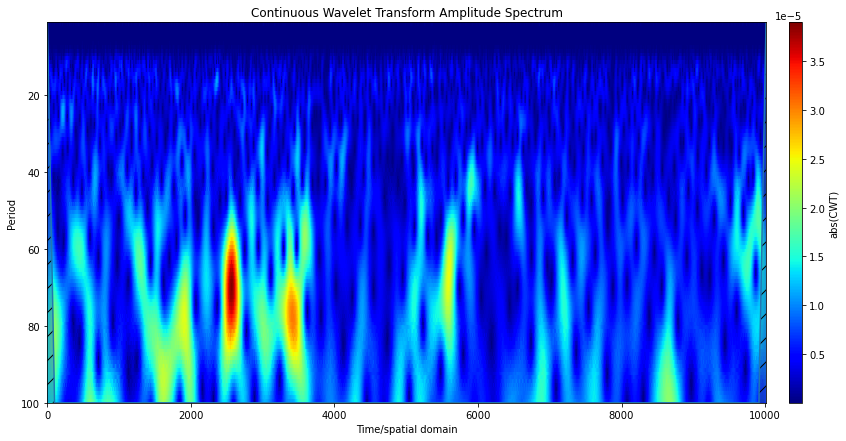

In [9]:
scales = scg.periods2scales(np.arange(1, 100, 1))
coikw = {'alpha': 0.5, 'hatch': '/'}

normed_sig = df_nino - df_nino.mean()
scg.cws(normed_sig, scales=scales, figsize=(14,7), coikw=coikw)

## References:

* Some <a href="https://youtu.be/jnxqHcObNK4">**cool video**</a> to dig deeper
* <a href="https://github.com/taspinar/siml">**Nice GitHub:**</a> Wavelets for Machine Learning
* Gentle <a href="https://www.kaggle.com/code/asauve/a-gentle-introduction-to-wavelet-for-data-analysis">**Introduction**</a> to Wavelets
* <a href="https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/">**A guide**</a> for using the Wavelet Transform in Machine Learning
* <a href="https://colab.research.google.com/drive/1u7klBcHHSsjVqIsbuIrKgSkDlo4wHkQm?usp=sharing">**A Colab**</a> with Wavelet Analysis 
